# Steel Casting Speed Modeling: Advanced Models

Mục tiêu: Đánh giá hiệu quả của hai phương pháp lọc outlier (IQR và Z-score) và áp dụng các mô hình Machine Learning nâng cao (Polynomial, Random Forest, XGBoost) để tối ưu hóa dự đoán tốc độ đúc cho mác thép **sae1006**.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb


# Cấu hình hiển thị
%matplotlib inline
sns.set(style="whitegrid")

## 1. Chuẩn bị dữ liệu

In [36]:
# Đọc file dữ liệu
file_path = '../01-data/TSC_clean.csv'
try:
    df = pd.read_csv(file_path)
    print("Đọc dữ liệu thành công!")
except FileNotFoundError:
    print(f"File không tồn tại: {file_path}")

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\3465228229.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Đọc dữ liệu thành công!


In [37]:
# 1. Lọc mác thép Contains 'sae1006'
target_grade = 'sae1006'
df_filtered = df[df['STEEL_GRADE_NAME'].str.contains(target_grade, case=False, na=False)].copy()

# 2. Làm sạch cơ bản
required_cols = ['speed', 'temperature', 'CUT_DATE', 'START_DATE', 'PROD_COUNTER']

df_clean = df_filtered.dropna(subset=required_cols)
df_clean = df_clean[(df['speed'] > 0) & (df['temperature'] >= 1500)]

print(f"Số lượng mẫu sau khi làm sạch: {len(df_clean)}")

# Feature Engineering: Time_In_Ladle
# Ensure datetime conversion worked
df_clean['CUT_DATE'] = pd.to_datetime(df_clean['CUT_DATE'], errors='coerce')
df_clean['START_DATE'] = pd.to_datetime(df_clean['START_DATE'], errors='coerce')
df_clean = df_clean.dropna(subset=['CUT_DATE', 'START_DATE'])

df_clean['time_in_ladle'] = (df_clean['CUT_DATE'] - df_clean['START_DATE']).dt.total_seconds() / 60.0

# Filter valid Time_In_Ladle (e.g., positive values)
df_done = df_clean[df_clean['time_in_ladle'] > 0]

print(f"Kích thước dữ liệu sau khi tiền xử lý: {df_done.shape}")

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\561977713.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[(df['speed'] > 0) & (df['temperature'] >= 1500)]


Số lượng mẫu sau khi làm sạch: 532527
Kích thước dữ liệu sau khi tiền xử lý: (532527, 20)


## 2. Lọc Outlier

In [38]:
# Hàm lọc IQR
def filter_iqr(df, cols):
    df_out = df.copy()
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

# Hàm lọc Z-score
def filter_zscore(df, cols, threshold=3):
    df_out = df.copy()
    z_scores = np.abs(stats.zscore(df_out[cols]))
    df_out = df_out[(z_scores < threshold).all(axis=1)]
    return df_out

# Áp dụng
cols_to_filter = ['speed', 'temperature', 'PROD_COUNTER', 'time_in_ladle']

df_iqr = filter_iqr(df_clean, cols_to_filter)
df_zscore = filter_zscore(df_clean, cols_to_filter, threshold=3)

print(f"Số mẫu sau khi lọc IQR: {len(df_iqr)}")
print(f"Số mẫu sau khi lọc Z-score: {len(df_zscore)}")

# Chọn dataset tốt nhất để tiếp tục (Giả định IQR cleaner)
df_final = df_iqr.copy()
print("Selecting IQR filtered dataset for advanced modeling.")

Số mẫu sau khi lọc IQR: 490274
Số mẫu sau khi lọc Z-score: 516751
Selecting IQR filtered dataset for advanced modeling.


## 3. Advanced Modeling

Chúng ta sẽ thử nghiệm 3 loại mô hình:
1. **Polynomial Regression (Degree 2, 3)**: Bắt đường cong phi tuyến tính.
2. **Random Forest**: Mô hình Ensemble mạnh mẽ, phi tuyến tính.
3. **XGBoost**: Gradient Boosting, thường cho kết quả tốt nhất trên dữ liệu bảng.

In [39]:
# Prepare Data
features = ['temperature', 'PROD_COUNTER', 'time_in_ladle']
target = 'speed'

X = df_final[features]
y = df_final[target]

print(f"Training on features: {features}")

# Split Train/Test (80/20) để đánh giá thực tế hơn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Danh sách kết quả
models_results = []

Training on features: ['temperature', 'PROD_COUNTER', 'time_in_ladle']


### 3.1 Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

# Khởi tạo và huấn luyện mô hình Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# In ra các hệ số của mô hình
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

models_results.append({'Model': 'Linear Regression', 'R2': r2, 'MSE': mse, 'MAE': mae})

Intercept: 36.760886579265836
Coefficients: [-0.02030897  0.11765862 -0.02437178]
Mean Absolute Error: 0.32530940273541625
Mean Squared Error: 0.18200446789431685
R^2 Score: 0.16979963531477127


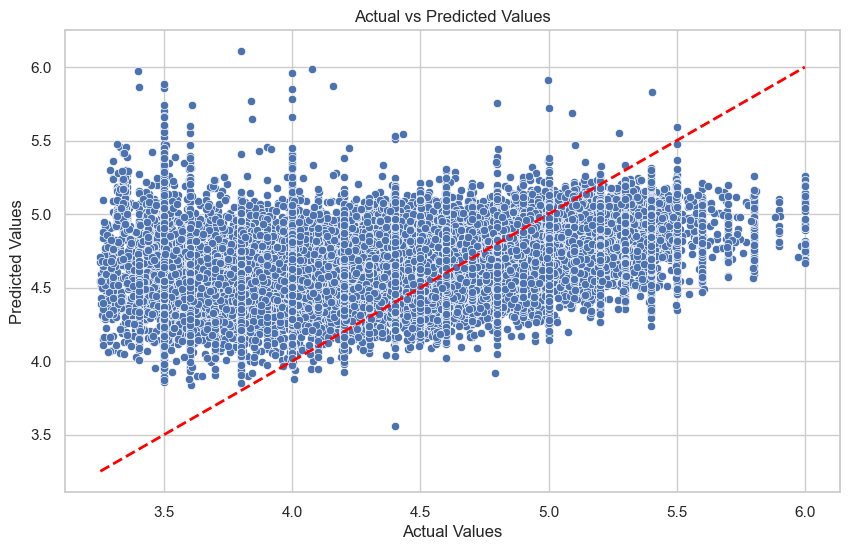

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Vẽ đồ thị so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

### 3.2 Random Forest (Hyperparameter Tuning)

In [42]:
# rf = RandomForestRegressor(random_state=42)
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 15, 20, 25],
#     'min_samples_leaf': [10, 20, 50],
#     'min_samples_split': [20, 50, 100],
#     'max_features': ['sqrt', 'log2']
# }

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid_rf,
#     n_iter=20,          # Chỉ chạy thử ngẫu nhiên 20 tổ hợp (Tiết kiệm thời gian)
#     cv=3,               # Cross-validation 3 lần
#     scoring='neg_mean_absolute_error', # Tối ưu hóa dựa trên MAE (Lưu ý: Scikit-learn dùng số âm)
#     verbose=2,          # Hiện tiến trình chạy
#     random_state=42,
#     n_jobs=-1           # Chạy song song đa luồng
# )

# print("Đang tìm tham số tối ưu (Tuning)...")
# random_search.fit(X_train, y_train)

# best_rf = random_search.best_estimator_
# y_pred_rf = best_rf.predict(X_test)

# # Tính toán các chỉ số
# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print("-" * 30)
# print(f"Best Parameters: {random_search.best_params_}")
# print("-" * 30)
# print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST:")
# print(f"R2 Score (Độ phù hợp): {r2:.4f} (Càng gần 1 càng tốt)")
# print(f"MSE (Sai số bình phương): {mse:.4f}")
# print(f"MAE (Sai số tuyệt đối): {mae:.4f} m/phút") 
# print("-" * 30)

# # Giải thích MAE cho sếp/đồng nghiệp:
# print(f"Diễn giải: Trung bình mô hình gợi ý tốc độ lệch khoảng {mae:.4f} m/phút so với thực tế.")

# models_results.append({'Model': 'Random Forest (Tuned)', 'R2': r2, 'MSE': mse, 'MAE': mae})

# print(f"Best RF Params: {grid_rf.best_params_}")

In [43]:
# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print("-" * 30)
# print(f"Best Parameters: {random_search.best_params_}")
# print("-" * 30)
# print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST:")
# print(f"R2 Score (Độ phù hợp): {r2:.4f} (Càng gần 1 càng tốt)")
# print(f"MSE (Sai số bình phương): {mse:.4f}")
# print(f"MAE (Sai số tuyệt đối): {mae:.4f} m/phút") 
# print("-" * 30)

# # Giải thích MAE cho sếp/đồng nghiệp:
# print(f"Diễn giải: Trung bình mô hình gợi ý tốc độ lệch khoảng {mae:.4f} m/phút so với thực tế.")

# models_results.append({'Model': 'Random Forest (Tuned)', 'R2': r2, 'MSE': mse, 'MAE': mae})

#### TRAIN LẠI VỚI BỘ THAM SỐ TỐT NHẤT 

In [44]:
# Initialize the model with the best parameters
best_params = {
    'n_estimators': 200,
    'min_samples_split': 50,
    'min_samples_leaf': 10,
    'max_features': 'log2',
    'max_depth': 20,
    'random_state': 42
}

rf_model = RandomForestRegressor(**best_params)

# Retrain the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

models_results.append({'Model': 'Random Forest', 'R2': r2, 'MSE': mse, 'MAE': mae})

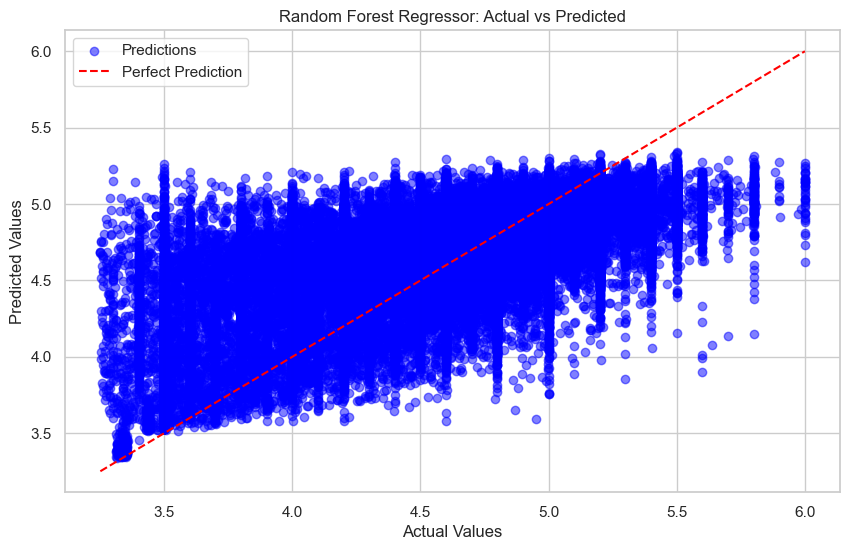

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### 3.3 XGBoost (Hyperparameter Tuning)

In [46]:
# # --- 1. GỢI Ý BỘ THAM SỐ XGBOOST ---
# param_dist_xgb = {
#     # Số lượng cây: XGBoost cần nhiều cây hơn nếu Learning Rate thấp
#     'n_estimators': [100, 300, 500],
    
#     # Tốc độ học (Learning Rate): Quan trọng nhất!
#     # 0.01: Học chậm, kỹ, cần nhiều cây (chính xác nhưng lâu).
#     # 0.1: Học nhanh vừa phải (Cân bằng).
#     # 0.3: Học nhanh, dễ bỏ qua chi tiết (kém chính xác hơn).
#     'learning_rate': [0.01, 0.05, 0.1],
    
#     # Độ sâu tối đa: XGBoost thường xây cây "nông" hơn Random Forest
#     # 6-10 là khoảng đẹp cho dữ liệu công nghiệp.
#     'max_depth': [5, 7, 10],
    
#     # Tỷ lệ mẫu dùng để train mỗi cây (Subsample)
#     # 0.7 nghĩa là: Chỉ lấy ngẫu nhiên 70% dữ liệu để xây 1 cây.
#     # -> Cực kỳ quan trọng để CHỐNG NHIỄU SENSOR (giống min_samples_leaf bên RF).
#     'subsample': [0.7, 0.8, 0.9],
    
#     # Tỷ lệ cột (feature) dùng cho mỗi cây
#     # Giúp model không bị phụ thuộc quá mức vào 1 biến (như Nhiệt độ)
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # --- 2. KHỞI TẠO MODEL ---
# # n_jobs=1 ở đây để dành CPU cho RandomizedSearchCV điều phối
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     random_state=42, 
#     n_jobs=1 
# )

# # --- 3. CẤU HÌNH RANDOMIZED SEARCH ---
# random_search_xgb = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist_xgb,
#     n_iter=20,                          # Thử ngẫu nhiên 20 tổ hợp
#     cv=3,                               # Kiểm tra chéo 3 lần
#     scoring='neg_mean_absolute_error',  # Tối ưu theo sai số tuyệt đối (MAE)
#     verbose=2,                          # Hiện tiến độ
#     random_state=42,
#     n_jobs=-1                           # Dùng hết CPU
# )

# print("Đang tìm tham số tối ưu cho XGBoost (Tuning)...")
# # Lưu ý: XGBoost train lâu hơn Random Forest một chút
# random_search_xgb.fit(X_train, y_train)

# # --- 4. ĐÁNH GIÁ KẾT QUẢ ---
# best_xgb = random_search_xgb.best_estimator_

# # Dự đoán
# y_pred_xgb = best_xgb.predict(X_test)

# # Tính toán chỉ số
# r2_xgb = r2_score(y_test, y_pred_xgb)
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb) # MAE quan trọng

# # Lưu kết quả vào danh sách tổng hợp để so sánh
# models_results.append({
#     'Model': 'XGBoost (Randomized Tuned)', 
#     'R2': r2_xgb, 
#     'MSE': mse_xgb,
#     'MAE': mae_xgb
# })

# print("-" * 30)
# print(f"Best XGB Params: {random_search_xgb.best_params_}")
# print("-" * 30)
# print("KẾT QUẢ XGBOOST:")
# print(f"R2 Score: {r2_xgb:.4f}")
# print(f"MAE (Sai số tuyệt đối): {mae_xgb:.4f} m/phút")
# print("-" * 30)

#### TRAIN LẠI VỚI BỘ THAM SỐ TỐT NHẤT 

In [65]:
# Initialize the model with the best parameters
best_params = {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

XGB_model = xgb.XGBRegressor(**best_params)

# Retrain the model on the training data
XGB_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = XGB_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

models_results.append({'Model': 'XGBoost', 'R2': r2, 'MSE': mse, 'MAE': mae})

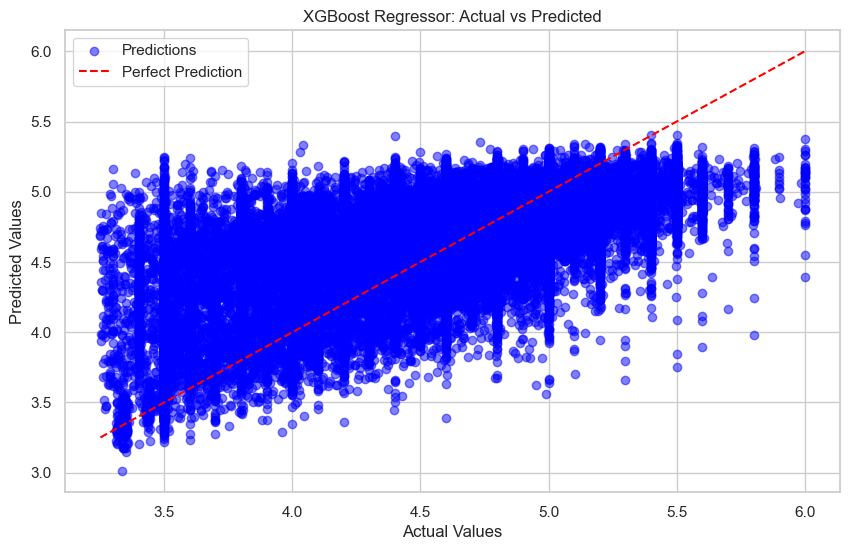

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## 4. Tổng hợp Kết quả

In [ ]:
results_df = pd.DataFrame(models_results).sort_values(by='MAE', ascending=True)
display(results_df)

,Model,R2,MSE,MAE
2,XGBoost,0.432746,0.124359,0.270768
1,Random Forest,0.433314,0.124234,0.271139
0,Linear Regression,0.169800,0.182004,0.325309


## 5. Kết luận & Đề xuất

In [60]:
# --- Polynomial Regression ---
degrees = [2, 3]

for degree in degrees:
    print(f"--- Polynomial Regression (Degree {degree}) ---")
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    y_pred = poly_model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
    # Store results
    models_results.append({'Model': f'Polynomial Regression (Degree {degree})', 'R2': r2, 'MSE': mse, 'MAE': mae})

--- Polynomial Regression (Degree 2) ---
Mean Absolute Error: 0.28315973631625074
Mean Squared Error: 0.13825864696395893
R^2 Score: 0.36934306911072745
--- Polynomial Regression (Degree 3) ---
Mean Absolute Error: 0.27873837590577333
Mean Squared Error: 0.13193517340073194
R^2 Score: 0.3981871415612829


In [61]:
# --- Summary Table ---
results_df = pd.DataFrame(models_results)
print("--- Model Comparison Summary ---")
print(results_df)

# Identify Best Model
best_model_row = results_df.loc[results_df['R2'].idxmax()]
print(f"Best Model based on R2 Score: {best_model_row['Model']} (R2: {best_model_row['R2']:.4f})")

--- Model Comparison Summary ---
                              Model        R2       MSE       MAE
0                 Linear Regression  0.169800  0.182004  0.325309
1                     Random Forest  0.433314  0.124234  0.271139
2                           XGBoost  0.432746  0.124359  0.270768
3  Polynomial Regression (Degree 2)  0.369343  0.138259  0.283160
4  Polynomial Regression (Degree 3)  0.398187  0.131935  0.278738
Best Model based on R2 Score: Random Forest (R2: 0.4333)


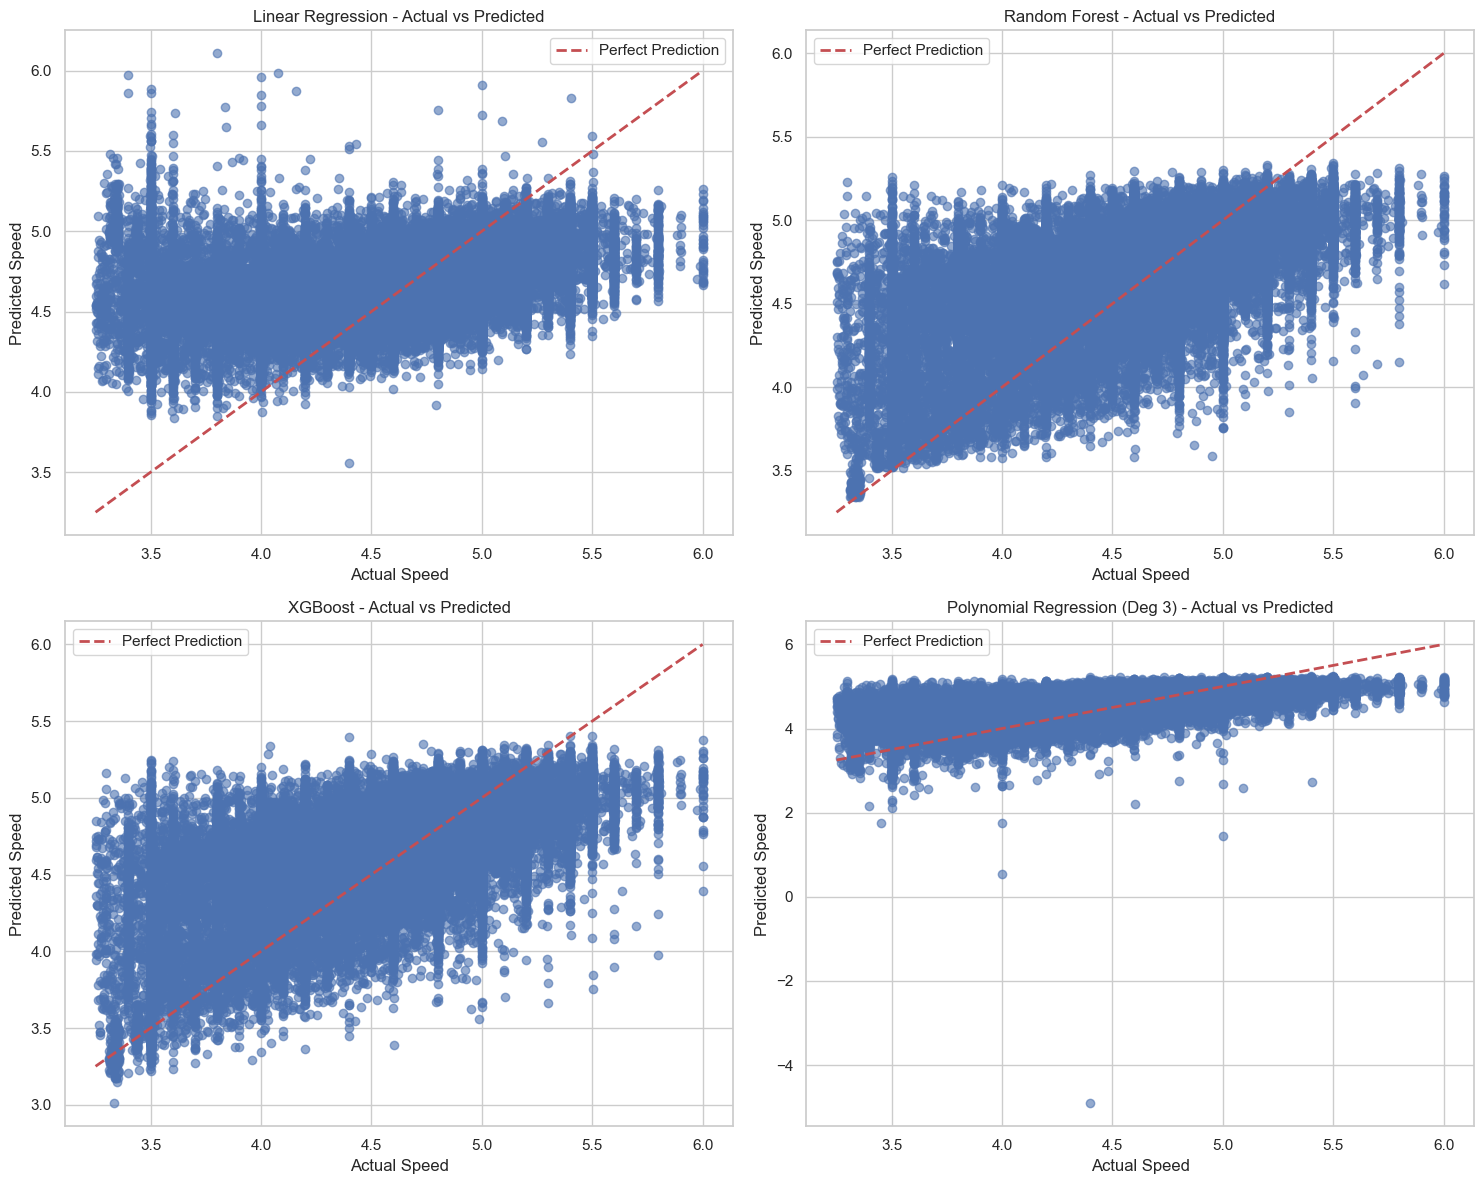

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\1702399625.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label=name, shade=True, alpha=0.3)
C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\1702399625.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label=name, shade=True, alpha=0.3)
C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\1702399625.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label=name, shade=True, alpha=0.3)
C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\1702399625.py:48: FutureWarning: 

`shade` is now deprecat

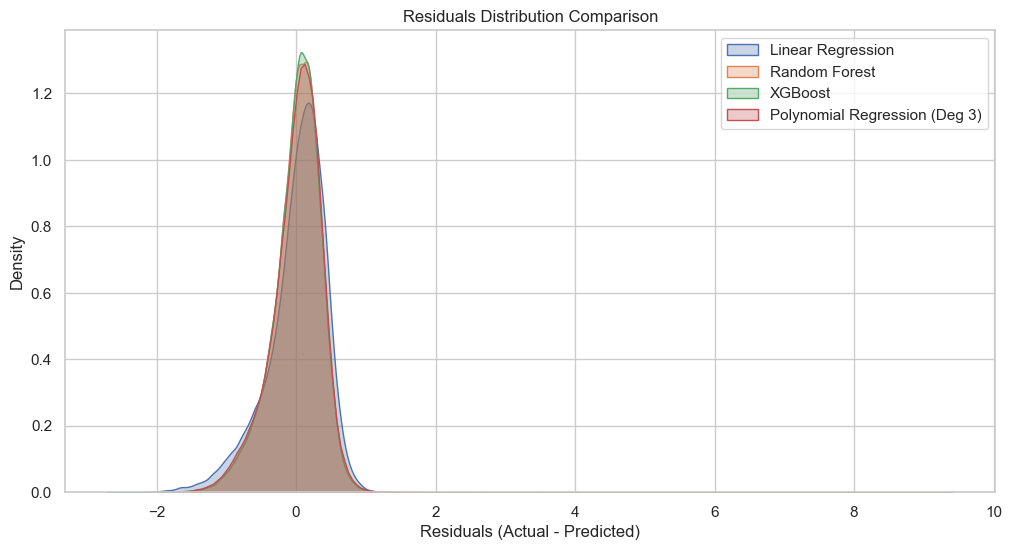

In [62]:
# --- Visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Define models for plotting (Using the last trained Poly model which is degree 3)
# Note: Need to verify if 'poly_model' corresponds to degree 3 from previous cell loop
poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(X_train) # Fit to ensure consistency

models_to_plot = [
    ('Linear Regression', model, None),
    ('Random Forest', rf_model, None),
    ('XGBoost', XGB_model, None),
    ('Polynomial Regression (Deg 3)', poly_model, poly_transformer)
]

for i, (name, mdl, transformer) in enumerate(models_to_plot):
    if transformer:
        # Transform X_test for Poly model
        X_test_plot = transformer.transform(X_test)
    else:
        X_test_plot = X_test
    
    y_pred_plot = mdl.predict(X_test_plot)
    
    # Scatter Plot
    ax = axes[i]
    ax.scatter(y_test, y_pred_plot, alpha=0.6, edgecolors='b')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax.set_title(f'{name} - Actual vs Predicted')
    ax.set_xlabel('Actual Speed')
    ax.set_ylabel('Predicted Speed')
    ax.legend()

plt.tight_layout()
plt.show()

# --- Residual Histograms ---
plt.figure(figsize=(12, 6))
for name, mdl, transformer in models_to_plot:
    if transformer:
        X_test_plot = transformer.transform(X_test)
    else:
        X_test_plot = X_test
        
    y_pred_plot = mdl.predict(X_test_plot)
    residuals = y_test - y_pred_plot
    sns.kdeplot(residuals, label=name, shade=True, alpha=0.3)

plt.title('Residuals Distribution Comparison')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Density')
plt.legend()
plt.show()

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\3972680746.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances[rf_indices], y=feature_names[rf_indices], ax=axes[0], palette='viridis')
C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_15920\3972680746.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances[xgb_indices], y=feature_names[xgb_indices], ax=axes[1], palette='magma')


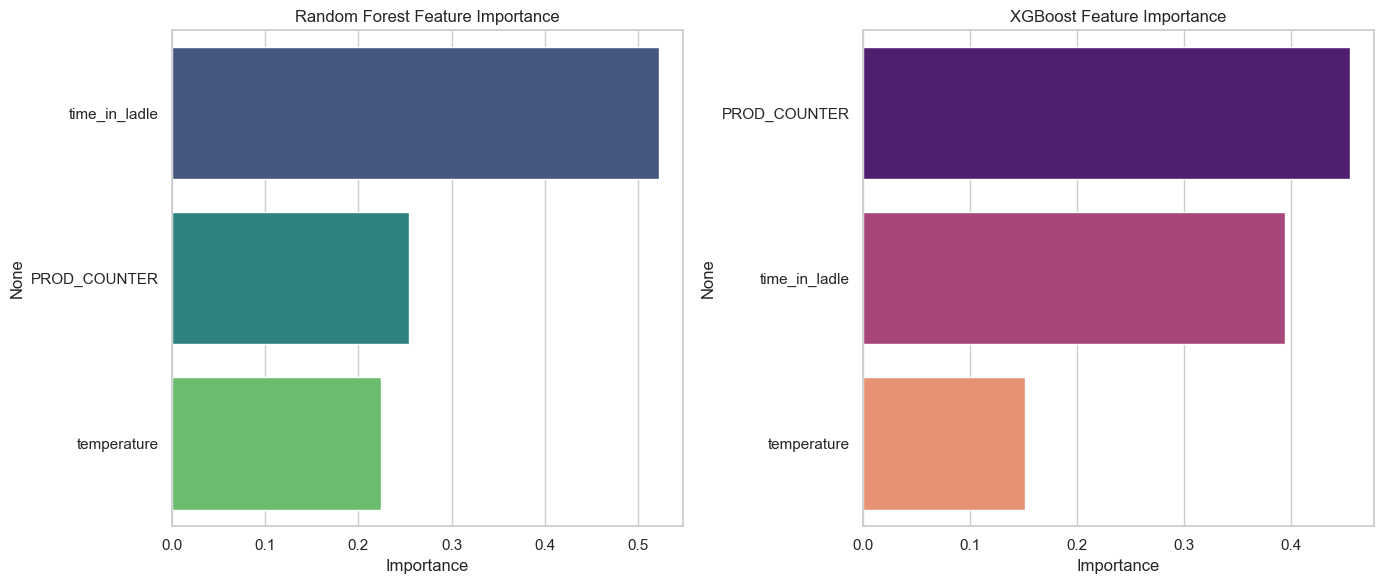

In [63]:
# --- Feature Importance ---
feature_names = X_train.columns

# Random Forest Importance
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

# XGBoost Importance
xgb_importances = XGB_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RF Plot
sns.barplot(x=rf_importances[rf_indices], y=feature_names[rf_indices], ax=axes[0], palette='viridis')
axes[0].set_title('Random Forest Feature Importance')
axes[0].set_xlabel('Importance')

# XGB Plot
sns.barplot(x=xgb_importances[xgb_indices], y=feature_names[xgb_indices], ax=axes[1], palette='magma')
axes[1].set_title('XGBoost Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()